In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import seaborn as sns

In [2]:
# import datasets
cust=pd.read_csv('CUSTOMERS.csv')
seller=pd.read_csv('SELLERS.csv')
prod=pd.read_csv('PRODUCTS.csv')
order=pd.read_csv('ORDERS.csv')
order_review=pd.read_csv('ORDER_REVIEW_RATINGS.csv')
item=pd.read_csv('ORDER_ITEMS.csv')
payment=pd.read_csv('ORDER_PAYMENTS.csv')
loc=pd.read_csv('GEO_LOCATION.csv')

#1. Perform Detailed exploratory analysis
#a. Define & calculate high level metrics like (Total Revenue, Total quantity, Total 
#products, Total categories, Total sellers, Total locations, Total channels, Total 
#payment methods etc…) 

In [3]:
# total revenue
tot_rev=payment['payment_value'].sum()
tot_rev

16008872.12

In [4]:
# total quantity
tot_quan=item['order_item_id'].count()
tot_quan

112650

In [5]:
# total products
tot_pro=prod['product_id'].count()
tot_pro

32951

In [6]:
# total categories
tot_cat=prod['product_category_name'].nunique()
tot_cat

71

In [7]:
# total sellers
tot_sellers=seller['seller_id'].count()
tot_sellers

3095

In [8]:
# total locations
tot_loc=loc['geolocation_state'].nunique()
tot_loc

20

In [10]:
# total payment methods
tot_pay_methods=payment['payment_type'].nunique()
tot_pay_methods

5

#b. Understanding how many new customers acquired every month

In [11]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [12]:
#  order_purchase_timestamp changing dtype from object to datetime
order['order_purchase_timestamp']=pd.to_datetime(order['order_purchase_timestamp'])

In [13]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.1+ MB


In [14]:
# first purchase date of each customer
first_purchase_date=order.groupby('customer_id')['order_purchase_timestamp'].min().reset_index()

In [15]:
# extracting month from  order_purchase_timestamp
first_purchase_date['month']=first_purchase_date['order_purchase_timestamp'].dt.month

In [16]:
# new customer per month
new_cust=first_purchase_date.groupby('month').size()
new_cust

month
1      8069
2      8508
3      9893
4      9343
5     10573
6      9412
7     10318
8     10843
9      4305
10     4959
11     7544
12     5674
dtype: int64

#c. Understand the retention of customers on month on month basis

C:\Users\Admin\AppData\Local\Temp\ipykernel_6740\2024185684.py:7: RuntimeWarning: invalid value encountered in scalar divide
  retention_rates = customer_retention.apply(lambda x: (x > 0).sum() / (x.shift(1) > 0).sum(), axis=0)


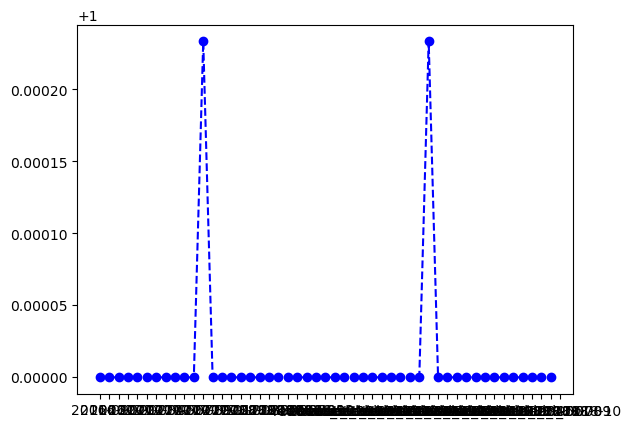

In [38]:
order['month'] = order['order_purchase_timestamp'].dt.to_period('M')
customer_months = order.groupby(['customer_id', 'month']).size().reset_index(name='purchases')
pivot_table = customer_months.pivot(index='customer_id', columns='month', values='purchases').fillna(0)
retention = pivot_table.apply(lambda x: x.shift(-1).fillna(0), axis=1)
retention.columns = ['retained_' + str(col) for col in retention.columns]
customer_retention = pd.concat([pivot_table, retention], axis=1)
retention_rates = customer_retention.apply(lambda x: (x > 0).sum() / (x.shift(1) > 0).sum(), axis=0)
months = [str(month) for month in retention_rates.index]
plt.plot(months, retention_rates.values, marker='o', linestyle='--', color='b')

#d. How the revenues from existing/new customers on month on month basis

In [18]:
# merging order table and order_payment table
tab1=pd.merge(order,payment,on='order_id',how='inner')

In [19]:
# first purchase month of each customer
tab1['first_purchase_month']=tab1.groupby('customer_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')

In [20]:
# extracting month from  order_purchase_timestamp
tab1['month']=tab1['order_purchase_timestamp'].dt.month

In [21]:
# creating new column to determine new and existing customers
tab1['cust_type']=tab1.apply(lambda x: 'new' if x['month'] == x['first_purchase_month'] else 'existing', axis=1)


In [22]:
# month wise revenue
tab1.groupby(['month','cust_type'])['payment_value'].sum()

month  cust_type
1      existing     1253492.22
2      existing     1284371.35
3      existing     1609515.72
4      existing     1578573.51
5      existing     1746900.97
6      existing     1535156.88
7      existing     1658923.67
8      existing     1696821.64
9      existing      732454.23
10     existing      839358.03
11     existing     1194882.80
12     existing      878421.10
Name: payment_value, dtype: float64

#e. Understand the trends/seasonality of sales, quantity by category, location, month, 
week, day, time, channel, payment method etc…

<Axes: ylabel='Count'>

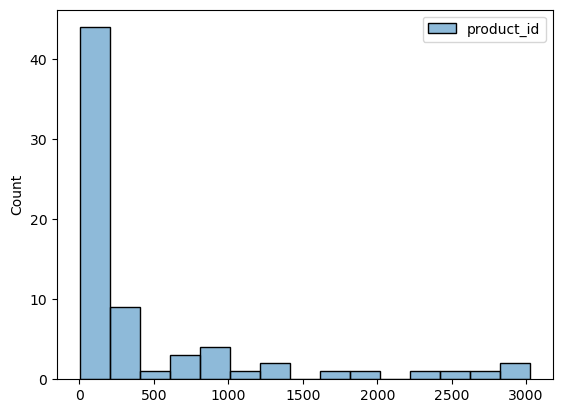

In [45]:
# quantity by category
quan_by_cat=prod.groupby('product_category_name')['product_id'].count().reset_index()
sns.histplot(data=quan_by_cat)

In [49]:
# quantity by month
quan_by_month=order.groupby('month')['customer_id'].count().reset_index()
quan_by_month.columns = ['month', 'count']
#plt.plot(quan_by_month['month'], quan_by_month['count'], label='Quantity by Month', marker='o')
quan_by_month

,month,count
0,2016-09,4
1,2016-10,324
2,2016-12,1
3,2017-01,800
4,2017-02,1780
5,2017-03,2682
6,2017-04,2404
7,2017-05,3700
8,2017-06,3245
9,2017-07,4026


<Axes: xlabel='payment_type', ylabel='count'>

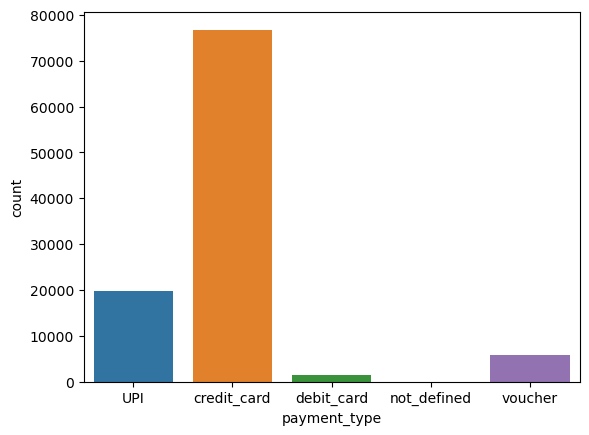

In [54]:
# quantity by payment method
quan_by_payment_method=payment.groupby('payment_type')['order_id'].count().reset_index()
quan_by_payment_method.columns = ['payment_type', 'count']
sns.barplot(data=quan_by_payment_method, x='payment_type', y='count')

In [70]:
# quantity by location
quan_by_loc=seller.groupby('seller_state')['seller_id'].count().reset_index()
quan_by_loc.columns = ['location', 'count']
#plt.figure(figsize=(10, 6))
#sns.lineplot(data=quan_by_loc, x='location', y='count')
quan_by_loc

,location,count
0,Andhra Pradesh,2060
1,Arunachal Pradesh,21
2,Chhattisgarh,205
3,Delhi,89
4,Gujarat,220
5,Haryana,65
6,Himachal Pradesh,16
7,Jammu & Kashmir,50
8,Karnataka,107
9,Kerala,18


#f. Popular Products by month, seller, state, category.

<Axes: xlabel='seller_id', ylabel='count'>

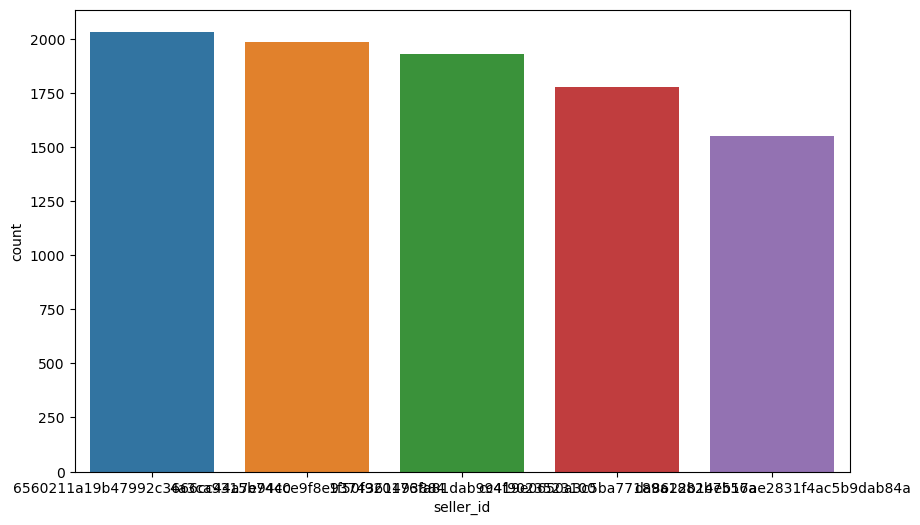

In [115]:
# popular products by seller
combined = item.merge(prod, on='product_id').merge(seller, on='seller_id') #combining the data sets
popular_by_seller = combined.groupby('seller_id')['product_id'].count().sort_values(ascending=False).head().reset_index()
popular_by_seller.columns = ['seller_id', 'count']
plt.figure(figsize=(10, 6))
sns.barplot(data=popular_by_seller, x='seller_id', y='count')

In [116]:
popular_by_seller

,seller_id,count
0,6560211a19b47992c3666cc44a7e94c0,2033
1,4a3ca9315b744ce9f8e9374361493884,1987
2,1f50f920176fa81dab994f9023523100,1931
3,cc419e0650a3c5ba77189a1882b7556a,1775
4,da8622b14eb17ae2831f4ac5b9dab84a,1551


<Axes: xlabel='month', ylabel='count'>

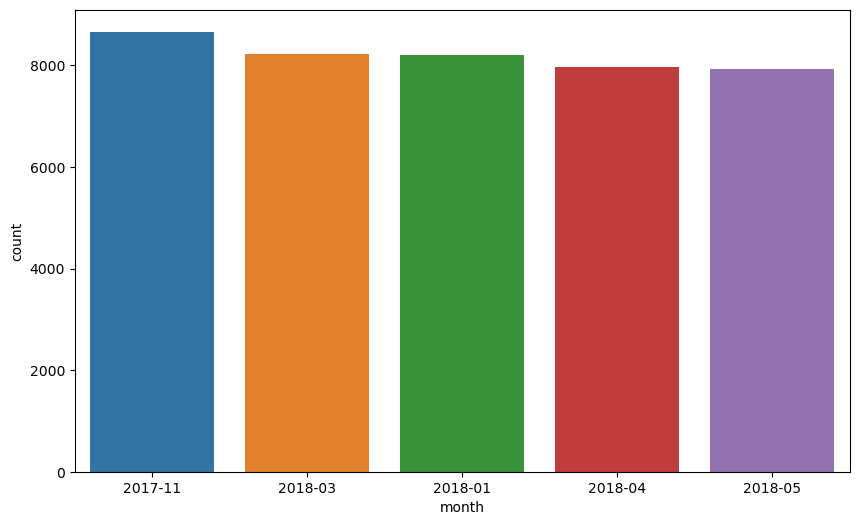

In [111]:
# popular by month
# combining combined and order data set
tab=pd.merge(combined,order,on='order_id',how='inner')
# popular by month
popular_by_month = tab.groupby('month')['product_id'].count().sort_values(ascending=False).head().reset_index()
popular_by_month.columns = ['month', 'count']
plt.figure(figsize=(10, 6))
sns.barplot(data=popular_by_month, x='month', y='count')

In [112]:
popular_by_month

,month,count
0,2017-11,8665
1,2018-03,8217
2,2018-01,8208
3,2018-04,7975
4,2018-05,7925


<Axes: xlabel='state', ylabel='count'>

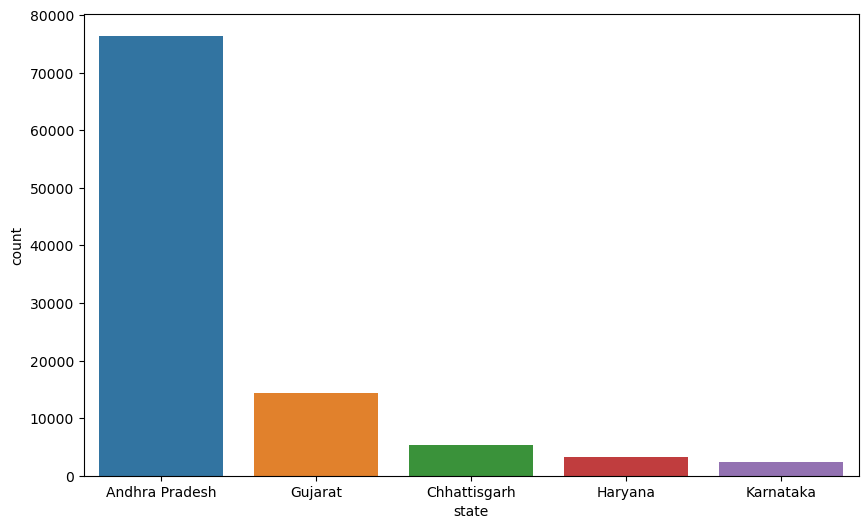

In [109]:
# popular by state
popular_by_state = combined.groupby('seller_state')['product_id'].count().sort_values(ascending=False).head().reset_index()
popular_by_state.columns = ['state', 'count']
plt.figure(figsize=(10, 6))
sns.barplot(data=popular_by_state, x='state', y='count')

In [110]:
popular_by_state

,state,count
0,Andhra Pradesh,76407
1,Gujarat,14295
2,Chhattisgarh,5327
3,Haryana,3293
4,Karnataka,2469


In [107]:
# popular products by category
popular_prod=prod.groupby('product_category_name')['product_id'].count().sort_values(ascending=False).head().reset_index()
popular_prod.columns = ['category', 'count']

<Axes: xlabel='category', ylabel='count'>

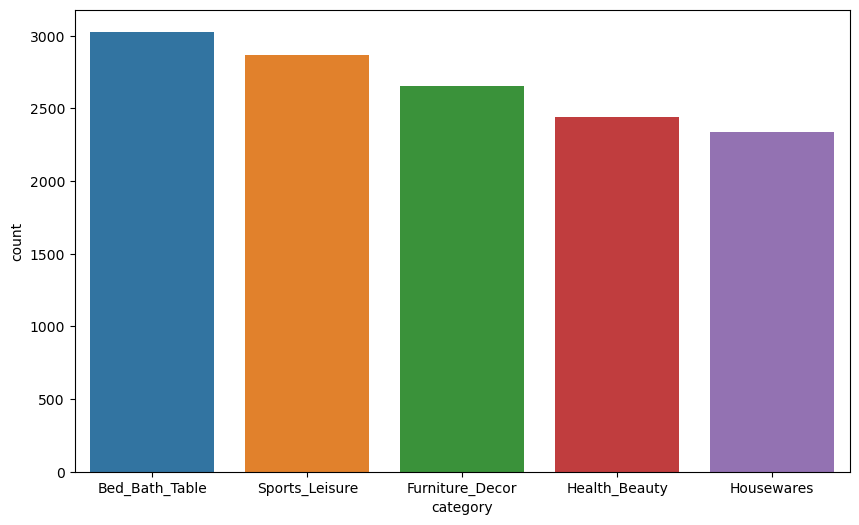

In [108]:
plt.figure(figsize=(10, 6))
sns.barplot(data=popular_prod, x='category', y='count')


#g. Popular categories by state, month

<Axes: xlabel='state', ylabel='count'>

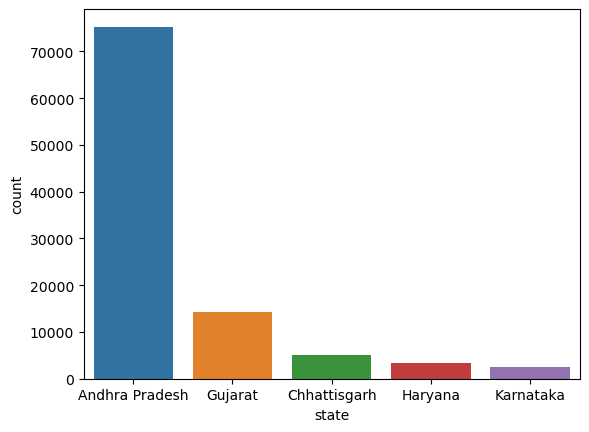

In [124]:
# popular categories by state
category_by_state=tab.groupby('seller_state')['product_category_name'].count().sort_values(ascending=False).head().reset_index()
category_by_state.columns=['state','count']
sns.barplot(data=category_by_state, x='state', y='count')


<Axes: xlabel='month', ylabel='count'>

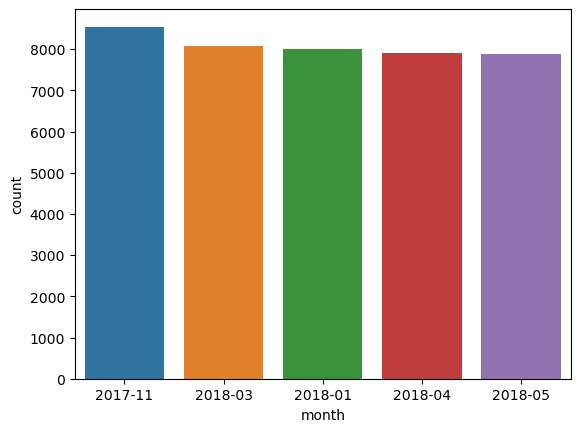

In [128]:
# popular categories by month
category_by_month=tab.groupby('month')['product_category_name'].count().sort_values(ascending=False).head().reset_index()
category_by_month.columns=['month','count']
sns.barplot(data=category_by_month, x='month', y='count')


#h. List top 10 most expensive products sorted by price

In [137]:
top_10_expensive_products = tab.sort_values(by='price', ascending=False).head(10)

In [140]:
top_10_expensive_products=top_10_expensive_products[['product_id','price']]
top_10_expensive_products

,product_id,price
96602,489ae2aa008f021502940f251d4cce7f,6735.00
112647,69c590f7ffc7bf8db97190b6cb6ed62e,6729.00
112615,1bdf5e6731585cf01aa8169c7028d6ad,6499.00
106703,a6492cc69376c469ab6f61d8f44de961,4799.00
106689,c3ed642d592594bb648ff4a04cee2747,4690.00
101609,259037a6a41845e455183f89c5035f18,4590.00
107152,a1beef8f3992dbd4cd8726796aa69c53,4399.87
84570,6cdf8fc1d741c76586d8b6b15e9eef30,4099.99
91640,dd113cb02b2af9c8e5787e8f1f0722f6,4059.00
52324,6902c1962dd19d540807d0ab8fade5c6,3999.90


#2. Performing Customers/sellers Segmentation
#a. Divide the customers into groups based on the revenue generated 

In [143]:
customer_revenue = tab.groupby('customer_id')['price'].sum().reset_index()
customer_revenue.columns = ['customer_id', 'total_revenue']
customer_revenue['groups'] = pd.qcut(customer_revenue['total_revenue'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
customer_revenue

,customer_id,total_revenue,groups
0,00012a2ce6f8dcda20d059ce98491703,89.80,High
1,000161a058600d5901f007fab4c27140,54.90,Medium
2,0001fd6190edaaf884bcaf3d49edf079,179.99,Very High
3,0002414f95344307404f0ace7a26f1d5,149.90,High
4,000379cdec625522490c315e70c7a9fb,93.00,High
...,...,...,...
98661,fffcb937e9dd47a13f05ecb8290f4d3e,78.00,Medium
98662,fffecc9f79fd8c764f843e9951b11341,54.90,Medium
98663,fffeda5b6d849fbd39689bb92087f431,47.90,Medium
98664,ffff42319e9b2d713724ae527742af25,199.90,Very High


#b. Divide the sellers into groups based on the revenue generated 

In [144]:
seller_revenue = tab.groupby('seller_id')['price'].sum().reset_index()
seller_revenue.columns = ['seller_id', 'total_revenue']
seller_revenue['groups'] = pd.qcut(seller_revenue['total_revenue'], 4, labels=['Low', 'Medium', 'High', 'Very High'])
seller_revenue

,seller_id,total_revenue,groups
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,High
1,001cca7ae9ae17fb1caed9dfb1094831,25080.03,Very High
2,001e6ad469a905060d959994f1b41e4f,250.00,Medium
3,002100f778ceb8431b7a1020ff7ab48f,1234.50,High
4,003554e2dce176b5555353e4f3555ac8,120.00,Low
...,...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,69.90,Low
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,2101.20,High
3092,ffeee66ac5d5a62fe688b9d26f83f534,1839.86,High
3093,fffd5413c0700ac820c7069d66d98c89,9062.30,Very High


#3. Cross-Selling (Which products are selling together)
#Hint: We need to find which of the top 10 combinations of products are selling together in 
#each transaction. (combination of 2 or 3 buying together)

In [148]:
#tab1=tab.groupby('order_id')['product_id'].apply(list).reset_index()
#tab1.sort_values(ascending=False)

#4. Payment Behaviour
#a. How customers are paying?

In [149]:
payment_behavior = payment.groupby('payment_type')['order_id'].count().reset_index()
payment_behavior.columns = ['payment_type', 'count']

<Axes: xlabel='payment_type', ylabel='count'>

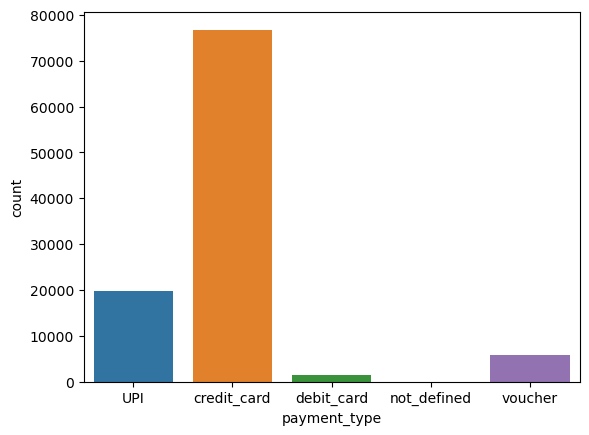

In [150]:
sns.barplot(data=payment_behavior, x='payment_type', y='count')

#b. Which payment channels are used by most customers?

In [151]:
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32328 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


#5. Customer satisfaction towards category & product
#a. Which categories (top 10) are maximum rated & minimum rated?

In [152]:
tab1=pd.merge(tab,order_review,on='order_id',how='inner')

In [154]:
category_ratings = tab1.groupby('product_category_name')['review_score'].mean().reset_index()
category_ratings.columns = ['product_category_name', 'review_score']

In [156]:
top_10_max_rated = category_ratings.sort_values(by='review_score', ascending=False).head(10)
top_10_max_rated

,product_category_name,review_score
11,Cds_Dvds_Musicals,4.642857
29,Fashion_Childrens_Clothes,4.500000
8,Books_General_Interest,4.439421
9,Books_Imported,4.400000
22,Costruction_Tools_Tools,4.359223
10,Books_Technical,4.338290
53,Luggage_Accessories,4.309524
37,Food_Drink,4.303571
64,Small_Appliances_Home_Oven_And_Coffee,4.302632
32,Fashion_Sport,4.258065


In [157]:
top_10_min_rated= category_ratings.sort_values(by='review_score', ascending=True).head(10)
top_10_min_rated

,product_category_name,review_score
61,Security_And_Services,2.500000
23,Diapers_And_Hygiene,3.256410
46,Home_Comfort_2,3.366667
57,Office_Furniture,3.484421
30,Fashion_Male_Clothing,3.621212
34,Fixed_Telephony,3.671698
58,Party_Supplies,3.767442
27,Fashio_Female_Clothing,3.780000
52,La_Cuisine,3.785714
4,Audio,3.808219


#b. Which products (top10) are maximum rated & minimum rated?

In [158]:
product_ratings = tab1.groupby('product_id')['review_score'].mean().reset_index()
product_ratings.columns = ['product_id', 'review_score']

In [159]:
top_10_max_rated = product_ratings.sort_values(by='review_score', ascending=False).head(10)
top_10_max_rated

,product_id,review_score
0,00066f42aeeb9f3007548bb9d3f33c38,5.0
17330,86743ff92eee3d16b7df59cddd583b8c,5.0
17345,868ceb027ab706a4dee42e2220006b85,5.0
17343,868969d3a93aeeab7bfcd4fc3d3d65de,5.0
17342,868766ed2172644fdd977d6bd395a107,5.0
17340,8684bd8f93b4f4038d07188a23811e93,5.0
17335,867c96d2bb67aba6500a4c509cf76072,5.0
17334,867b820367ec206b38a357f2c12454b7,5.0
17333,867901d7e8488fb97f1fb538c09d476e,5.0
17325,865bfa00c1dad8f4146d3c2765f051ca,5.0


In [160]:
top_10_min_rated= product_ratings.sort_values(by='review_score', ascending=True).head(10)
top_10_min_rated

,product_id,review_score
11572,592cc6634d2c783d297effc0b828bc37,1.0
5376,28c95d7653177449fd4b6fc7adb63ce9,1.0
5378,28d6d6a10ceb0636ae572e7efafef612,1.0
5379,28d7da9ebe96bfda54aed060b68b23a1,1.0
18040,8c4e5e50a08a443b7fbad34ad7587625,1.0
18039,8c4dc358af6e14174f2114be62c18f37,1.0
18034,8c4456c061013adccb1ba4cbce2d0365,1.0
18030,8c35dc99b37ba51780800ba049ed3616,1.0
5409,28fe66c8a81afe9be7829f40a5fae9ee,1.0
30663,ee37349d258101b9d573a256d1401ff7,1.0


#c. Average rating by location, seller, product, category, month etc

In [163]:
# rating by location
location_ratings = tab1.groupby('seller_state')['review_score'].mean().reset_index()
location_ratings.columns = ['seller_state', 'review_score']
location_ratings

,seller_state,review_score
0,Andhra Pradesh,4.019711
1,Arunachal Pradesh,4.154248
2,Chhattisgarh,4.111963
3,Delhi,3.884944
4,Gujarat,3.936198
5,Haryana,4.074761
6,Himachal Pradesh,4.149554
7,Jammu & Kashmir,4.043765
8,Karnataka,4.033441
9,Kerala,4.243902


In [164]:
# rating by seller
seller_ratings = tab1.groupby('seller_id')['review_score'].mean().reset_index()
seller_ratings.columns = ['seller_id', 'review_score']
seller_ratings

,seller_id,review_score
0,0015a82c2db000af6aaaf3ae2ecb0532,3.666667
1,001cca7ae9ae17fb1caed9dfb1094831,3.874477
2,001e6ad469a905060d959994f1b41e4f,1.000000
3,002100f778ceb8431b7a1020ff7ab48f,3.982143
4,003554e2dce176b5555353e4f3555ac8,5.000000
...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,1.000000
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,4.250000
3092,ffeee66ac5d5a62fe688b9d26f83f534,4.214286
3093,fffd5413c0700ac820c7069d66d98c89,3.885246


In [165]:
# rating by product
product_ratings

,product_id,review_score
0,00066f42aeeb9f3007548bb9d3f33c38,5.0
1,00088930e925c41fd95ebfe695fd2655,4.0
2,0009406fd7479715e4bef61dd91f2462,1.0
3,000b8f95fcb9e0096488278317764d19,5.0
4,000d9be29b5207b54e86aa1b1ac54872,5.0
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,4.5
32947,fff81cc3158d2725c0655ab9ba0f712c,4.0
32948,fff9553ac224cec9d15d49f5a263411f,5.0
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,5.0


In [166]:
# rating by category
category_ratings

,product_category_name,review_score
0,Agro_Industry_And_Commerce,4.000000
1,Air_Conditioning,3.919192
2,Art,3.918660
3,Arts_And_Craftmanship,4.125000
4,Audio,3.808219
...,...,...
66,Stationery,4.181386
67,Tablets_Printing_Image,4.048193
68,Telephony,3.935604
69,Toys,4.138667


In [167]:
# rating by months
month_ratings = tab1.groupby('month')['review_score'].mean().reset_index()
month_ratings.columns = ['month', 'review_score']
month_ratings

,month,review_score
0,2016-09,1.000000
1,2016-10,3.567935
2,2016-12,5.000000
3,2017-01,4.052795
4,2017-02,4.042813
5,2017-03,4.041722
6,2017-04,3.987375
7,2017-05,4.118364
8,2017-06,4.118265
9,2017-07,4.126835
